# Data Processing MERRA-2
Starting from ARTMIP Tier 1 MERRA-2 source data

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import xesmf as xe
import nc_time_axis
import cftime 
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import matplotlib.colors as mcolors
import matplotlib as mpl
import datetime
import pandas as pd
#import zarr

In [2]:
# Import dask
import dask

# Use dask jobqueue
from dask_jobqueue import PBSCluster

# Import a client
from dask.distributed import Client

# Setup your PBSCluster
nmem1 = '10GiB' # PBSCluster specification
nmem2 = '10GB' # pbs specification
cluster = PBSCluster(
    cores=1, # The number of cores you want
    memory=nmem1, # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='/glade/derecho/scratch/kdagon/dask-local', # Use your local directory
    resource_spec='select=1:ncpus=1:mem='+nmem2, # Specify resources
    account='P06010014', # Input your project ID here
    walltime='00:30:00', # Amount of wall time
    interface='ext', # Interface to use
)

# Scale up -- how to determine this number?
cluster.scale(40) # 25 (at least) for processing 3hrly data
#cluster.scale(10)

# Change your url to the dask dashboard so you can see it
#dask.config.set({'distributed.dashboard.link':'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'})

# Setup your client
client = Client(cluster)

/glade/work/kdagon/conda-envs/PEx_v2/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 42155 instead
  warnings.warn(


In [3]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kdagon/Casper CPU CCR/proxy/42155/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kdagon/Casper CPU CCR/proxy/42155/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.179:44979,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kdagon/Casper CPU CCR/proxy/42155/status,Total threads: 0
Started: Just now,Total memory: 0 B


## MERRA IWV, U/V 850

In [4]:
#merra_data_path = '/glade/campaign/collections/gdex/data/d651012/merra2_2000-2017/' # PS, IVT, uIVT, vIVT, IWV; no time coordinate information in these files, goes through June 30, 2017
#merra_data_path = '/glade/campaign/collections/cdg/data/ARTMIP/FULL_2D_MERRA2/' # same vars as above; yearly folders; time as "record" dimension
merra_data_path = '/glade/campaign/cgd/ccr/shields/MERRA2/ARTMIP/MERRA_UV/' # IWV, U850 or 700, V850 or 700; single files separated by u/v level; time as "record" dimension

In [5]:
merra_data_file = 'ARTMIP_MERRA2_shields_uv850_1980-2017.nc'

### Read in data

In [6]:
%%time
# individual files; running out of hub memory (4gb)
#merra_dataset = xr.open_mfdataset(merra_data_path+file_years, combine='nested', chunks='auto', parallel=True, preprocess=preprocess_merra)
#merra_dataset

# single file
#merra_dataset = xr.open_dataset(merra_data_path+merra_data_file, chunks='auto') # auto chunking worked well here for the 3 variables in this file, fast to read in
#merra_dataset = xr.open_dataset(merra_data_path+merra_data_file, chunks={}) # single chunk
#merra_dataset = xr.open_dataset(merra_data_path+merra_data_file, chunks={'record':128}) # chunk in time only based on # timesteps and desired chunksize - this is super important
merra_dataset = xr.open_dataset(merra_data_path+merra_data_file, chunks={'record':250}) # modifying this initial chunk based on desired final # chunks for writing out regridding output
#merra_dataset

CPU times: user 647 ms, sys: 226 ms, total: 873 ms
Wall time: 1.92 s


### Rename record dimension

In [7]:
merra_dataset = merra_dataset.rename({'record': 'time'})
#merra_dataset

In [20]:
# double check chunks
merra_dataset.IWV

<xarray.DataArray 'IWV' (time: 109568, lat: 361, lon: 576)> Size: 91GB
dask.array<open_dataset-IWV, shape=(109568, 361, 576), dtype=float32, chunksize=(250, 361, 576), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 3kB -90.0 -89.5 -89.0 -88.5 ... 88.5 89.0 89.5 90.0
  * lon      (lon) float64 5kB -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
Dimensions without coordinates: time
Attributes:
    time:            0
    lev:             1000.0
    _ChunkSizes:     [  1   1  91 144]
    valid_range:     [-1.e+15  1.e+15]
    vmin:            -1000000000000000.0
    vmax:            1000000000000000.0
    standard_name:   eastward_wind
    fmissing_value:  1000000000000000.0
    units:           mm
    long_name:       Integrated Water Vapor
    short_name:      IWV

In [8]:
merra_dataset.u

<xarray.DataArray 'u' (time: 109568, lev: 1, lat: 361, lon: 576)> Size: 91GB
dask.array<open_dataset-u, shape=(109568, 1, 361, 576), dtype=float32, chunksize=(250, 1, 361, 576), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 3kB -90.0 -89.5 -89.0 -88.5 ... 88.5 89.0 89.5 90.0
  * lev      (lev) float64 8B 850.0
  * lon      (lon) float64 5kB -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
Dimensions without coordinates: time
Attributes:
    time:            0
    _ChunkSizes:     [  1   1  91 144]
    valid_range:     [-1.e+15  1.e+15]
    vmin:            -1000000000000000.0
    vmax:            1000000000000000.0
    standard_name:   eastward_wind
    fmissing_value:  1000000000000000.0
    units:           m s-1
    long_name:       eastward_wind

### Set datetime

In [8]:
merra_dt = np.arange(np.datetime64('1980-01-01T00:00:00.000000000'), np.datetime64('2017-07-01T00:00:00.000000000'), np.timedelta64(3, "h"))
#merra_dt = np.arange(np.datetime64('1980-01-01T00:00:00'), np.datetime64('2017-07-01T00:00:00'), np.timedelta64(3, "h")) # try to not include ns for writing out
#merra_dt = np.arange(np.datetime64('1980-01-01T00'), np.datetime64('2017-07-01T00'), np.timedelta64(3, "h")) # try to not include ns for writing out
#merra_dt = np.arange(datetime.datetime(1980,1,1,0), datetime.datetime(2017,7,1,0), datetime.timedelta(hours=3)) # trying python datetime, but still converts to datetime64[us] (worse??)
merra_dt
#len(merra_dt)

array(['1980-01-01T00:00:00.000000000', '1980-01-01T03:00:00.000000000',
       '1980-01-01T06:00:00.000000000', ...,
       '2017-06-30T15:00:00.000000000', '2017-06-30T18:00:00.000000000',
       '2017-06-30T21:00:00.000000000'], dtype='datetime64[ns]')

In [9]:
# assign to merra data
merra_dataset['time'] = merra_dt
merra_dataset.time

<xarray.DataArray 'time' (time: 109568)> Size: 877kB
array(['1980-01-01T00:00:00.000000000', '1980-01-01T03:00:00.000000000',
       '1980-01-01T06:00:00.000000000', ..., '2017-06-30T15:00:00.000000000',
       '2017-06-30T18:00:00.000000000', '2017-06-30T21:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 877kB 1980-01-01 ... 2017-06-30T21:00:00

### Subset IWV, 2000-2015

In [11]:
merra_iwv = merra_dataset['IWV'].sel(time=slice('2000','2015'))
merra_iwv

<xarray.DataArray 'IWV' (time: 46752, lat: 361, lon: 576)> Size: 39GB
dask.array<getitem, shape=(46752, 361, 576), dtype=float32, chunksize=(128, 361, 576), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 3kB -90.0 -89.5 -89.0 -88.5 ... 88.5 89.0 89.5 90.0
  * lon      (lon) float64 5kB -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
  * time     (time) datetime64[ns] 374kB 2000-01-01 ... 2015-12-31T21:00:00
Attributes:
    time:            0
    lev:             1000.0
    _ChunkSizes:     [  1   1  91 144]
    valid_range:     [-1.e+15  1.e+15]
    vmin:            -1000000000000000.0
    vmax:            1000000000000000.0
    standard_name:   eastward_wind
    fmissing_value:  1000000000000000.0
    units:           mm
    long_name:       Integrated Water Vapor
    short_name:      IWV

In [12]:
# Try one year only
merra_iwv_2000 = merra_dataset['IWV'].sel(time=slice('2000','2000'))
merra_iwv_2000

<xarray.DataArray 'IWV' (time: 2928, lat: 361, lon: 576)> Size: 2GB
dask.array<getitem, shape=(2928, 361, 576), dtype=float32, chunksize=(2928, 41, 65), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 3kB -90.0 -89.5 -89.0 -88.5 ... 88.5 89.0 89.5 90.0
  * lon      (lon) float64 5kB -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
  * time     (time) datetime64[s] 23kB 2000-01-01 ... 2000-12-31T21:00:00
Attributes:
    time:            0
    lev:             1000.0
    _ChunkSizes:     [  1   1  91 144]
    valid_range:     [-1.e+15  1.e+15]
    vmin:            -1000000000000000.0
    vmax:            1000000000000000.0
    standard_name:   eastward_wind
    fmissing_value:  1000000000000000.0
    units:           mm
    long_name:       Integrated Water Vapor
    short_name:      IWV

In [11]:
# rechunk to reduce # chunks
merra_iwv_2000 = merra_iwv_2000.chunk({"time": 2928, "lat": 200, "lon": 200})
merra_iwv_2000

<xarray.DataArray 'IWV' (time: 2928, lat: 361, lon: 576)> Size: 2GB
dask.array<rechunk-merge, shape=(2928, 361, 576), dtype=float32, chunksize=(2928, 200, 200), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 3kB -90.0 -89.5 -89.0 -88.5 ... 88.5 89.0 89.5 90.0
  * lon      (lon) float64 5kB -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
  * time     (time) datetime64[s] 23kB 2000-01-01 ... 2000-12-31T21:00:00
Attributes:
    time:            0
    lev:             1000.0
    _ChunkSizes:     [  1   1  91 144]
    valid_range:     [-1.e+15  1.e+15]
    vmin:            -1000000000000000.0
    vmax:            1000000000000000.0
    standard_name:   eastward_wind
    fmissing_value:  1000000000000000.0
    units:           mm
    long_name:       Integrated Water Vapor
    short_name:      IWV

In [20]:
# try a single chunk for 2001
merra_iwv_2001 = merra_dataset['IWV'].sel(time=slice('2001','2001')).chunk({"time": 2928, "lat": 361, "lon": 576})
merra_iwv_2001

<xarray.DataArray 'IWV' (time: 2920, lat: 361, lon: 576)> Size: 2GB
dask.array<rechunk-merge, shape=(2920, 361, 576), dtype=float32, chunksize=(2920, 361, 576), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 3kB -90.0 -89.5 -89.0 -88.5 ... 88.5 89.0 89.5 90.0
  * lon      (lon) float64 5kB -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
  * time     (time) datetime64[s] 23kB 2001-01-01 ... 2001-12-31T21:00:00
Attributes:
    time:            0
    lev:             1000.0
    _ChunkSizes:     [  1   1  91 144]
    valid_range:     [-1.e+15  1.e+15]
    vmin:            -1000000000000000.0
    vmax:            1000000000000000.0
    standard_name:   eastward_wind
    fmissing_value:  1000000000000000.0
    units:           mm
    long_name:       Integrated Water Vapor
    short_name:      IWV

### Calculate mean/std 
For comparison to TMQ-trained model normalization values

In [12]:
merra_iwv.mean().values

array(17.83555, dtype=float32)

In [13]:
merra_iwv.std().values

array(16.15375, dtype=float32)

### Quick plot

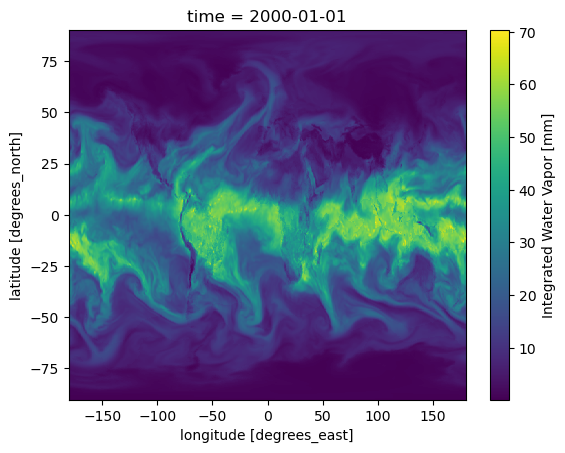

In [18]:
merra_iwv.isel(time=0).plot();

## Subset U/V 850

In [10]:
merra_u850 = merra_dataset['u'].squeeze(drop=True).sel(time=slice('2000','2015')) # drop the single-indexed level (add to attributes later)
merra_u850

<xarray.DataArray 'u' (time: 46752, lat: 361, lon: 576)> Size: 39GB
dask.array<getitem, shape=(46752, 361, 576), dtype=float32, chunksize=(250, 361, 576), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 3kB -90.0 -89.5 -89.0 -88.5 ... 88.5 89.0 89.5 90.0
  * lon      (lon) float64 5kB -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
  * time     (time) datetime64[ns] 374kB 2000-01-01 ... 2015-12-31T21:00:00
Attributes:
    time:            0
    _ChunkSizes:     [  1   1  91 144]
    valid_range:     [-1.e+15  1.e+15]
    vmin:            -1000000000000000.0
    vmax:            1000000000000000.0
    standard_name:   eastward_wind
    fmissing_value:  1000000000000000.0
    units:           m s-1
    long_name:       eastward_wind

### Calculate mean/std 
For comparison to training data

In [12]:
%%time
merra_u850.mean().values

CPU times: user 5.9 s, sys: 326 ms, total: 6.22 s
Wall time: 43.8 s


array(1.5647624, dtype=float32)

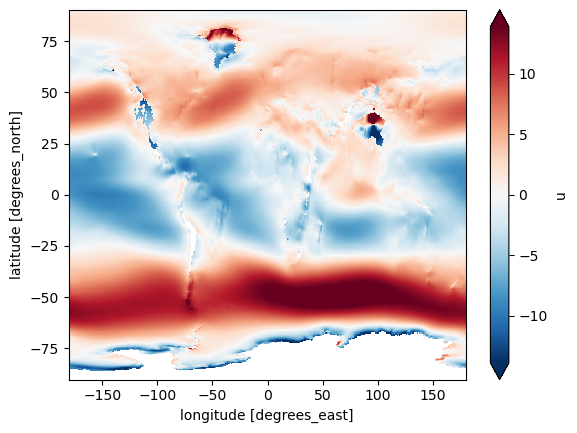

In [25]:
merra_u850.mean(dim='time').plot(robust=True);

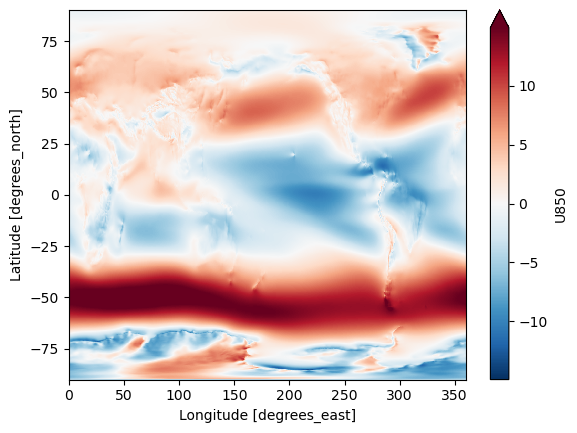

In [26]:
UV850_cesm_month.U850.mean(dim='time').plot(robust=True);

In [13]:
%%time
merra_u850.std().values

CPU times: user 4.89 s, sys: 352 ms, total: 5.24 s
Wall time: 34.8 s


array(8.603418, dtype=float32)

In [27]:
merra_month = xr.open_dataset("/glade/campaign/cgd/ccr/kdagon/cgnet/MERRA-2/MERRA2_monthly_masked_2000-2015.nc", chunks={'time':100}) # fixed 3hrly data for spurious non-nan points at high elevations

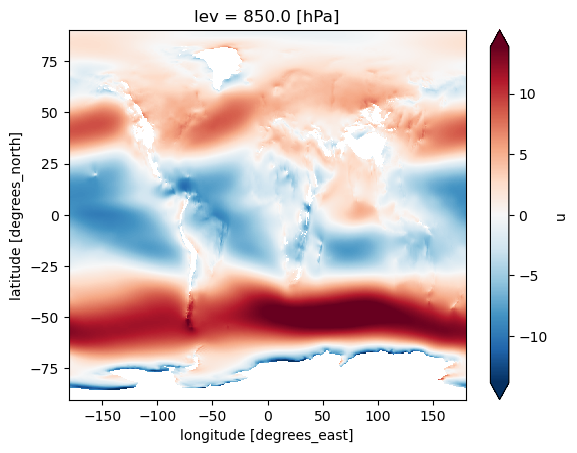

In [30]:
merra_month.u.mean(dim='time').plot(robust=True);

In [31]:
merra_month.u.mean().values # better!

array(1.5658824, dtype=float32)

In [11]:
merra_v850 = merra_dataset['v'].squeeze(drop=True).sel(time=slice('2000','2015'))
merra_v850

<xarray.DataArray 'v' (time: 46752, lat: 361, lon: 576)> Size: 39GB
dask.array<getitem, shape=(46752, 361, 576), dtype=float32, chunksize=(250, 361, 576), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 3kB -90.0 -89.5 -89.0 -88.5 ... 88.5 89.0 89.5 90.0
  * lon      (lon) float64 5kB -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
  * time     (time) datetime64[ns] 374kB 2000-01-01 ... 2015-12-31T21:00:00
Attributes:
    time:            0
    _ChunkSizes:     [  1   1  91 144]
    valid_range:     [-1.e+15  1.e+15]
    vmin:            -1000000000000000.0
    vmax:            1000000000000000.0
    standard_name:   northward_wind
    fmissing_value:  1000000000000000.0
    units:           m s-1
    long_name:       northward_wind

### Calculate mean/std 
For comparison to training data

In [14]:
merra_v850.mean().values

array(0.04962943, dtype=float32)

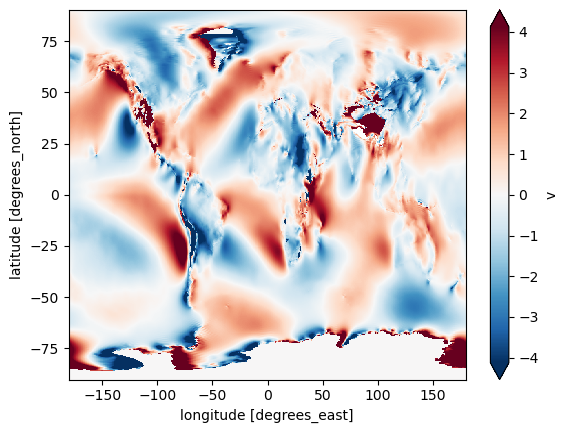

In [24]:
# the mean value is low compared to CESM/training data
merra_v850.mean(dim='time').plot(robust=True);

In [19]:
# quick visual comparison to CESM
UV850_cesm_month = xr.open_dataset("/glade/campaign/cgd/ccr/kdagon/cgnet/B20TRC5CN/CESM_hist_UV850_monthly_2000-2015.nc", chunks={'time':50})
UV850_cesm_month

<xarray.Dataset> Size: 1GB
Dimensions:  (lat: 768, lon: 1152, time: 192)
Coordinates:
  * lat      (lat) float64 6kB -90.0 -89.77 -89.53 -89.3 ... 89.53 89.77 90.0
  * lon      (lon) float64 9kB 0.0 0.3125 0.625 0.9375 ... 359.1 359.4 359.7
  * time     (time) object 2kB 2000-01-31 00:00:00 ... 2015-12-31 00:00:00
Data variables:
    U850     (time, lat, lon) float32 679MB dask.array<chunksize=(50, 768, 1152), meta=np.ndarray>
    V850     (time, lat, lon) float32 679MB dask.array<chunksize=(50, 768, 1152), meta=np.ndarray>

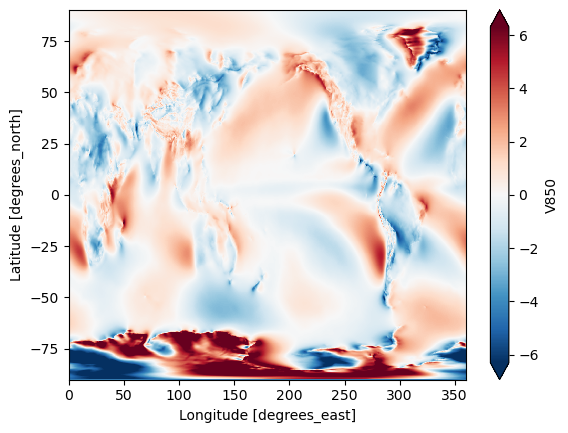

In [22]:
UV850_cesm_month.V850.mean(dim='time').plot(robust=True);

Issue could be related to higher V850 values over Antarctic in CESM, especially since this is an unweighted global mean comparison\
MERRA doesn't appear to have data over Antarctica, which makes sense\
Is it due to the spurious non-nan values at high elevations that I discovered previously? The processed monthly file fixed this with masking

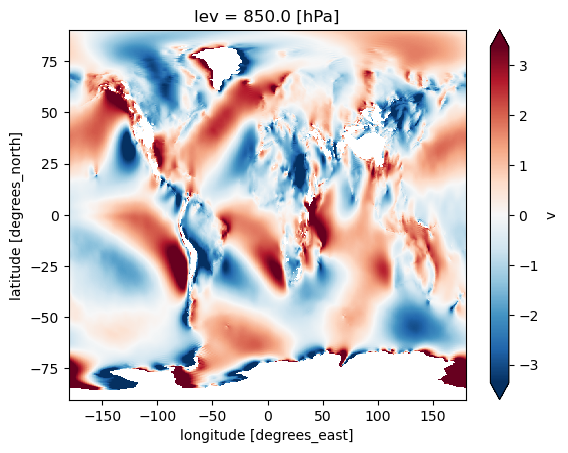

In [32]:
merra_month.v.mean(dim='time').plot(robust=True);

In [33]:
merra_month.v.mean().values # the value is still low here even with high elevation masking! so it must be Antarctic or something else

array(0.04661456, dtype=float32)

In [15]:
merra_v850.std().values

array(6.4346027, dtype=float32)

### Make a U/V dataset

In [13]:
merra_uv = xr.Dataset({'U850': merra_u850, 'V850': merra_v850}) # rename data variables in this step as well
merra_uv

<xarray.Dataset> Size: 78GB
Dimensions:  (lat: 361, lon: 576, time: 46752)
Coordinates:
  * lat      (lat) float64 3kB -90.0 -89.5 -89.0 -88.5 ... 88.5 89.0 89.5 90.0
  * lon      (lon) float64 5kB -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
  * time     (time) datetime64[ns] 374kB 2000-01-01 ... 2015-12-31T21:00:00
Data variables:
    U850     (time, lat, lon) float32 39GB dask.array<chunksize=(60, 361, 576), meta=np.ndarray>
    V850     (time, lat, lon) float32 39GB dask.array<chunksize=(60, 361, 576), meta=np.ndarray>

## Save out intermediate file

In [14]:
merra_savedir = '/glade/campaign/cgd/ccr/kdagon/cgnet/MERRA-2/'

The time estimate for persist isn't accurate, have to watch the dask dashboard\
9/18/25: took about ~10-15min to persist with 20GB x 25 workers; doesn't seem to speed up `to_netcdf`\
Update xarray didn't seem to help much\
Changing datetime to [s] instead of [ns] seems to help persist speed

In [ ]:
%%time
merra_iwv = merra_iwv.persist()

In [18]:
%%time
merra_iwv_2000 = merra_iwv_2000.persist()

CPU times: user 3.47 ms, sys: 0 ns, total: 3.47 ms
Wall time: 3.39 ms


9/18/25: Started 10:26am with 20GB x 25 workers and failed at last task at 10:33am? Connection error based on worker logs? Try again...\
Started 10:36am with 20GB x 25 workers. Noting CPUs are all at high percentages so could be worth increasing # workers. Died again on last task at 10:43am so it must be the compute command.\
Trying 10GB x 30 workers with datetime64[s] instead of [ns] but it still fails at the very end (kills the kernel)

In [ ]:
%%time
merra_iwv = merra_iwv.compute()

So far change to [s] from [ns] does not seem to be changing save out speed with faster persist first

In [ ]:
%%time
merra_iwv.to_netcdf(merra_savedir+'MERRA2_IWV_3hr_2000-2015.nc')

### Finally got something to save out!
Rechunked, year 2000 only, datetime64[s] took 14min on 10GB x 30 workers

In [19]:
%%time
merra_iwv_2000.to_netcdf(merra_savedir+'MERRA2_IWV_3hr_2000.nc')

CPU times: user 1min 39s, sys: 6.45 s, total: 1min 45s
Wall time: 14min


Did not like having a single chunk

In [ ]:
%%time
merra_iwv_2001.to_netcdf(merra_savedir+'MERRA2_IWV_3hr_2001.nc')

Write out 16 year subset (no rechunking)\
This is generally fast (1min for 16 years), even with time in datetime64[ns]

In [14]:
%%time
# write out 16 year file
#merra_iwv.to_netcdf(merra_savedir+'MERRA2_IWV_3hr_2000-2015.nc')
merra_iwv.to_netcdf(merra_savedir+'MERRA2_IWV_3hr_2000-2015_ns.nc')

CPU times: user 9.13 s, sys: 565 ms, total: 9.7 s
Wall time: 56.8 s


2 mins to save out uv850 dataset

In [34]:
%%time
merra_uv.to_netcdf(merra_savedir+'MERRA2_UV850_3hr_2000-2015.nc')

CPU times: user 19 s, sys: 839 ms, total: 19.9 s
Wall time: 1min 59s


### Try saving to zarr
Did not like chunking\
ValueError: Zarr requires uniform chunk sizes except for final chunk. Variable named 'IWV' has incompatible dask chunks: ((4500, 12588, 12588, 12588, 4488), (41, 41, 41, 41, 41, 41, 41, 41, 33), (65, 65, 65, 65, 65, 65, 65, 65, 56)). Consider rechunking using `chunk()`.

In [ ]:
%%time
merra_iwv.to_zarr(merra_savedir+'MERRA2_IWV_3hr_2000-2015.zarr')

## Regrid
From: native MERRA-2 0.5deg\
To: CESM 0.25deg

### Read in MERRA test file
From previously saved workflow

In [4]:
merra_savedir = '/glade/campaign/cgd/ccr/kdagon/cgnet/MERRA-2/'

In [16]:
#merra_iwv_subset = xr.open_dataarray(merra_savedir+'MERRA2_IWV_3hr_2000-2015.nc', chunks={'time':1000}) # time chunking chosen for chunksize and related to # workers
merra_iwv_subset = xr.open_dataarray(merra_savedir+'MERRA2_IWV_3hr_2000-2015_ns.nc', chunks={'time':250}) # time chunking chosen for chunksize and related to # workers
merra_iwv_subset

<xarray.DataArray 'IWV' (time: 46752, lat: 361, lon: 576)> Size: 39GB
dask.array<open_dataset-IWV, shape=(46752, 361, 576), dtype=float32, chunksize=(250, 361, 576), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 3kB -90.0 -89.5 -89.0 -88.5 ... 88.5 89.0 89.5 90.0
  * lon      (lon) float64 5kB -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
  * time     (time) datetime64[ns] 374kB 2000-01-01 ... 2015-12-31T21:00:00
Attributes:
    _ChunkSizes:     [  1   1  91 144]
    long_name:       Integrated Water Vapor
    fmissing_value:  1000000000000000.0
    time:            0
    short_name:      IWV
    standard_name:   eastward_wind
    vmax:            1000000000000000.0
    units:           mm
    valid_range:     [-1.e+15  1.e+15]
    lev:             1000.0
    vmin:            -1000000000000000.0

In [22]:
merra_iwv_2000 = xr.open_dataarray(merra_savedir+'MERRA2_IWV_3hr_2000.nc', chunks='auto', decode_times=False) # trying without decoding time to datetime64[ns]
merra_iwv_2000

<xarray.DataArray 'IWV' (time: 2928, lat: 361, lon: 576)> Size: 2GB
dask.array<open_dataset-IWV, shape=(2928, 361, 576), dtype=float32, chunksize=(1116, 137, 219), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 3kB -90.0 -89.5 -89.0 -88.5 ... 88.5 89.0 89.5 90.0
  * lon      (lon) float64 5kB -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
  * time     (time) int64 23kB 0 3 6 9 12 15 ... 8766 8769 8772 8775 8778 8781
Attributes:
    _ChunkSizes:     [  1   1  91 144]
    long_name:       Integrated Water Vapor
    fmissing_value:  1000000000000000.0
    time:            0
    short_name:      IWV
    standard_name:   eastward_wind
    vmax:            1000000000000000.0
    units:           mm
    valid_range:     [-1.e+15  1.e+15]
    lev:             1000.0
    vmin:            -1000000000000000.0

### Read in CESM file for the grid

In [15]:
cesm_file = '/glade/campaign/cgd/ccr/kdagon/cgnet/B20TRC5CN/2000/2000_all_vars_split000001.nc'

In [16]:
cesm_ds = xr.open_dataset(cesm_file)
cesm_ds

<xarray.Dataset> Size: 14MB
Dimensions:    (time: 1, bnds: 2, slat: 767, lat: 768, lon: 1152)
Coordinates:
  * time       (time) object 8B 2000-01-01 03:00:00
  * slat       (slat) float64 6kB -89.88 -89.65 -89.41 ... 89.41 89.65 89.88
  * lat        (lat) float64 6kB -90.0 -89.77 -89.53 -89.3 ... 89.53 89.77 90.0
  * lon        (lon) float64 9kB 0.0 0.3125 0.625 0.9375 ... 359.1 359.4 359.7
Dimensions without coordinates: bnds
Data variables: (12/20)
    time_bnds  (time, bnds) object 16B ...
    lat_bnds   (lat, bnds) float64 12kB ...
    lon_bnds   (lon, bnds) float64 18kB ...
    w_stag     (slat) float64 6kB ...
    gw         (lat) float64 6kB ...
    TMQ        (time, lat, lon) float32 4MB ...
    ...         ...
    ndcur      (time) int32 4B ...
    nscur      (time) int32 4B ...
    nsteph     (time) int32 4B ...
    sol_tsi    (time) float64 8B ...
    PSL        (time, lat, lon) float32 4MB ...
    V850       (time, lat, lon) float32 4MB ...
Attributes: (12/21)
    CDI:                        Climate Data Interface version 2.0.2 (https:/...
    Conventions:                CF-1.0
    source:                     CAM
    history:                    Fri Feb 17 16:11:24 2023: cdo splitsel,1 2000...
    remap_script:               ncremap
    remap_command:              '/glade/u/apps/dav/opt/nco/4.7.9/gnu/8.3.0/bi...
    ...                         ...
    Version:                    $Name$
    revision_Id:                $Id$
    initial_file:               /projects/ccsm/inputdata/atm/cam/inic/homme/c...
    topography_file:            /projects/ccsm/inputdata/atm/cam/topo/USGS-gt...
    history_of_appended_files:  Fri Feb 17 15:31:33 2023: Appended file 2000_...
    CDO:                        Climate Data Operators version 2.0.1 (https:/...

### Regridding

#### IWV

In [17]:
%%time
regridder = xe.Regridder(merra_iwv, cesm_ds, "bilinear", periodic=True)
#regridder = xe.Regridder(merra_iwv_2000, cesm_ds, "bilinear", periodic=True)
#regridder = xe.Regridder(merra_iwv_subset, cesm_ds, "bilinear", periodic=True)
regridder

NameError: name 'merra_iwv' is not defined

In [16]:
regridder.weights

Format,coo
Data Type,float64
Shape,"(884736, 207936)"
nnz,3538944
Density,1.9236688211757463e-05
Read-only,True
Size,54.0M
Storage ratio,0.00


Save out the map file just in case it can be used to remap in the command line

In [26]:
%%time
# save out the map file
regridder.to_netcdf(merra_savedir+'merra0.5_to_cesm0.25_weights.nc')

CPU times: user 20.7 ms, sys: 36.5 ms, total: 57.2 ms
Wall time: 80.3 ms


'/glade/campaign/cgd/ccr/kdagon/cgnet/MERRA-2/merra0.5_to_cesm0.25_weights.nc'

In [17]:
%%time
#merra_iwv_cesmgrid = regridder(merra_iwv, keep_attrs=True)
#merra_iwv_cesmgrid = regridder(merra_iwv_2000, keep_attrs=True)
#merra_iwv_cesmgrid = regridder(merra_iwv_subset, keep_attrs=True, output_chunks={'time':250,'lat':-1, 'lon':-1}) # preserve single space chunk in move to new spatial dimensions
merra_iwv_cesmgrid = regridder(merra_iwv, keep_attrs=True, output_chunks={'time':250,'lat':-1, 'lon':-1}) # trying without intermediate file; does change results since we chunked differently with intermediate file read in
merra_iwv_cesmgrid

CPU times: user 2.37 s, sys: 205 ms, total: 2.57 s
Wall time: 5.12 s


<xarray.DataArray 'IWV' (time: 46752, lat: 768, lon: 1152)> Size: 165GB
dask.array<astype, shape=(46752, 768, 1152), dtype=float32, chunksize=(128, 768, 1152), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 374kB 2000-01-01 ... 2015-12-31T21:00:00
  * lat      (lat) float64 6kB -90.0 -89.77 -89.53 -89.3 ... 89.53 89.77 90.0
  * lon      (lon) float64 9kB 0.0 0.3125 0.625 0.9375 ... 359.1 359.4 359.7
Attributes:
    time:            0
    lev:             1000.0
    _ChunkSizes:     [  1   1  91 144]
    valid_range:     [-1.e+15  1.e+15]
    vmin:            -1000000000000000.0
    vmax:            1000000000000000.0
    standard_name:   eastward_wind
    fmissing_value:  1000000000000000.0
    units:           mm
    long_name:       Integrated Water Vapor
    short_name:      IWV
    regrid_method:   bilinear

This was fast - just a test of the regridding

In [56]:
%%time
merra_iwv_cesmgrid = merra_iwv_cesmgrid.persist()

CPU times: user 17.8 ms, sys: 4 ms, total: 21.8 ms
Wall time: 22.1 ms


/glade/work/kdagon/conda-envs/PEx_v2/lib/python3.11/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 81.07 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


#### u/v850

In [18]:
%%time
regridder = xe.Regridder(merra_uv, cesm_ds, "bilinear", periodic=True)
regridder

CPU times: user 15.3 s, sys: 602 ms, total: 15.9 s
Wall time: 15.5 s


xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_361x576_768x1152_peri.nc 
Reuse pre-computed weights? False 
Input grid shape:           (361, 576) 
Output grid shape:          (768, 1152) 
Periodic in longitude?      True

In [19]:
%%time
merra_uv_cesmgrid = regridder(merra_uv, keep_attrs=True, output_chunks={'time':250,'lat':-1, 'lon':-1})
merra_uv_cesmgrid

CPU times: user 2.31 s, sys: 150 ms, total: 2.46 s
Wall time: 2.43 s


<xarray.Dataset> Size: 331GB
Dimensions:  (time: 46752, lat: 768, lon: 1152)
Coordinates:
  * time     (time) datetime64[ns] 374kB 2000-01-01 ... 2015-12-31T21:00:00
  * lat      (lat) float64 6kB -90.0 -89.77 -89.53 -89.3 ... 89.53 89.77 90.0
  * lon      (lon) float64 9kB 0.0 0.3125 0.625 0.9375 ... 359.1 359.4 359.7
Data variables:
    U850     (time, lat, lon) float32 165GB dask.array<chunksize=(60, 768, 1152), meta=np.ndarray>
    V850     (time, lat, lon) float32 165GB dask.array<chunksize=(60, 768, 1152), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

### Test saving out regridded file before assigning attributes

Worked so well! No chunks in space! Chunksize ~843MB in time only\
Still get task graph size warning (81MB) but ok

In [19]:
%%time
merra_iwv_cesmgrid.to_netcdf(merra_savedir+'MERRA2_IWV_3hr_regrid_2000-2015.nc')

/glade/work/kdagon/conda-envs/PEx_v2/lib/python3.11/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 81.06 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


CPU times: user 8.67 s, sys: 626 ms, total: 9.3 s
Wall time: 1min 3s


Rechunk for larger/fewer chunks (unclear how to choose here)

In [25]:
merra_iwv_cesmgrid = merra_iwv_cesmgrid.chunk({"time": 2928, "lat": 200, "lon": 200}) # 24 chunks 446.78MB each
merra_iwv_cesmgrid

<xarray.DataArray 'IWV' (time: 2928, lat: 768, lon: 1152)> Size: 10GB
dask.array<rechunk-merge, shape=(2928, 768, 1152), dtype=float32, chunksize=(2928, 200, 200), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) int64 23kB 0 3 6 9 12 15 ... 8766 8769 8772 8775 8778 8781
  * lat      (lat) float64 6kB -90.0 -89.77 -89.53 -89.3 ... 89.53 89.77 90.0
  * lon      (lon) float64 9kB 0.0 0.3125 0.625 0.9375 ... 359.1 359.4 359.7
Attributes:
    _ChunkSizes:     [  1   1  91 144]
    long_name:       Integrated Water Vapor
    fmissing_value:  1000000000000000.0
    time:            0
    short_name:      IWV
    standard_name:   eastward_wind
    vmax:            1000000000000000.0
    units:           mm
    valid_range:     [-1.e+15  1.e+15]
    lev:             1000.0
    vmin:            -1000000000000000.0
    regrid_method:   bilinear

Once regridded, one year doesn't have enough memory on 10gb x 30 workers but it did work on 20gb x 25 workers

In [26]:
%%time
merra_iwv_cesmgrid = merra_iwv_cesmgrid.persist()

CPU times: user 44.3 ms, sys: 0 ns, total: 44.3 ms
Wall time: 43.4 ms


/glade/work/kdagon/conda-envs/PEx_v2/lib/python3.11/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 81.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


### Quick plot

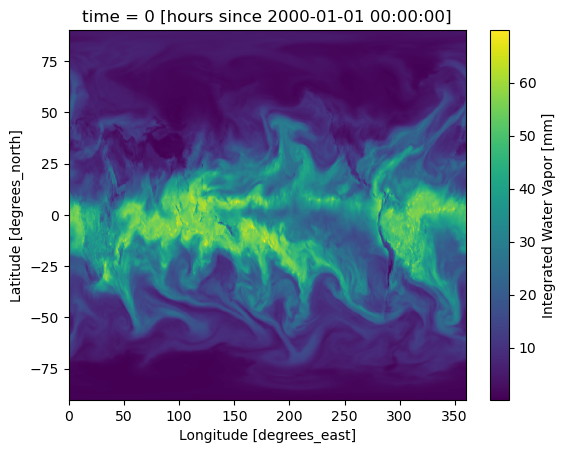

In [27]:
merra_iwv_cesmgrid.isel(time=0).plot();

CPU times: user 1.06 s, sys: 142 ms, total: 1.2 s
Wall time: 6.65 s


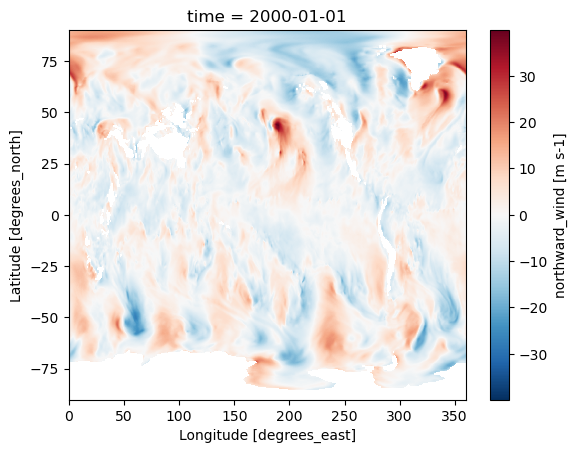

In [42]:
%%time
merra_uv_cesmgrid['V850'].isel(time=0).plot();

## Rename and set attributes

In [20]:
merra_tmq = merra_iwv_cesmgrid.rename('TMQ')
merra_tmq

<xarray.DataArray 'TMQ' (time: 46752, lat: 768, lon: 1152)> Size: 165GB
dask.array<astype, shape=(46752, 768, 1152), dtype=float32, chunksize=(250, 768, 1152), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 374kB 2000-01-01 ... 2015-12-31T21:00:00
  * lat      (lat) float64 6kB -90.0 -89.77 -89.53 -89.3 ... 89.53 89.77 90.0
  * lon      (lon) float64 9kB 0.0 0.3125 0.625 0.9375 ... 359.1 359.4 359.7
Attributes:
    _ChunkSizes:     [  1   1  91 144]
    long_name:       Integrated Water Vapor
    fmissing_value:  1000000000000000.0
    time:            0
    short_name:      IWV
    standard_name:   eastward_wind
    vmax:            1000000000000000.0
    units:           mm
    valid_range:     [-1.e+15  1.e+15]
    lev:             1000.0
    vmin:            -1000000000000000.0
    regrid_method:   bilinear

In [21]:
merra_tmq = merra_tmq.assign_attrs({'long_name' : 'Total precipitable water',
                        'short_name' : 'TMQ',
                        'standard_name' : 'total_precipitable_water',
                        'units' : 'kg/m2',
                        'time' : '2000-2015',
                        #'time' : '2000',
                        #'_ChunkSizes' : '[12588 41 65]',
                        'title' : '3-hr averaged MERRA-2 Water Vapor',
                        'summary' : 'Create MERRA-2 regridded input for ClimateNet application',
                        'creator' : 'Katie Dagon, kdagon@ucar.edu',
                        'contact' : 'Katie Dagon, kdagon@ucar.edu',
                        'script' : 'jupyter notebook at /glade/work/kdagon/ML-extremes/notebooks/Data_Processing_MERRA_IWV.ipynb',
                        'conventions' : 'CF 1.0',
                        'creation_date' : datetime.date.today().strftime('%Y-%m-%d'),
                       })
merra_tmq

<xarray.DataArray 'TMQ' (time: 46752, lat: 768, lon: 1152)> Size: 165GB
dask.array<astype, shape=(46752, 768, 1152), dtype=float32, chunksize=(250, 768, 1152), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 374kB 2000-01-01 ... 2015-12-31T21:00:00
  * lat      (lat) float64 6kB -90.0 -89.77 -89.53 -89.3 ... 89.53 89.77 90.0
  * lon      (lon) float64 9kB 0.0 0.3125 0.625 0.9375 ... 359.1 359.4 359.7
Attributes: (12/19)
    _ChunkSizes:     [  1   1  91 144]
    long_name:       Total precipitable water
    fmissing_value:  1000000000000000.0
    time:            2000-2015
    short_name:      TMQ
    standard_name:   total_precipitable_water
    ...              ...
    summary:         Create MERRA-2 regridded input for ClimateNet application
    creator:         Katie Dagon, kdagon@ucar.edu
    contact:         Katie Dagon, kdagon@ucar.edu
    script:          jupyter notebook at /glade/work/kdagon/ML-extremes/noteb...
    conventions:     CF 1.0
    creation_date:   2025-09-30

In [20]:
# variable attributes
merra_uv_cesmgrid['U850'] = merra_uv_cesmgrid['U850'].assign_attrs({'long_name' : 'Eastward wind at 850hPa',
                        'short_name' : 'U850',
                        'time' : '2000-2015'
                       })
merra_uv_cesmgrid['V850'] = merra_uv_cesmgrid['V850'].assign_attrs({'long_name' : 'Northward wind at 850hPa',
                                                                    'short_name' : 'V850',
                                                                    'time' : '2000-2015'
                                                                   })
merra_uv_cesmgrid.V850

<xarray.DataArray 'V850' (time: 46752, lat: 768, lon: 1152)> Size: 165GB
dask.array<astype, shape=(46752, 768, 1152), dtype=float32, chunksize=(250, 768, 1152), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 374kB 2000-01-01 ... 2015-12-31T21:00:00
  * lat      (lat) float64 6kB -90.0 -89.77 -89.53 -89.3 ... 89.53 89.77 90.0
  * lon      (lon) float64 9kB 0.0 0.3125 0.625 0.9375 ... 359.1 359.4 359.7
Attributes:
    time:            2000-2015
    _ChunkSizes:     [  1   1  91 144]
    valid_range:     [-1.e+15  1.e+15]
    vmin:            -1000000000000000.0
    vmax:            1000000000000000.0
    standard_name:   northward_wind
    fmissing_value:  1000000000000000.0
    units:           m s-1
    long_name:       Northward wind at 850hPa
    short_name:      V850

In [21]:
# dataset attributes
merra_uv_cesmgrid = merra_uv_cesmgrid.assign_attrs({'time' : '2000-2015',
                                  'title' : '3-hr averaged MERRA-2 850hPa winds',
                                  'summary' : 'Create MERRA-2 regridded input for ClimateNet application',
                                  'creator' : 'Katie Dagon, kdagon@ucar.edu',
                                  'contact' : 'Katie Dagon, kdagon@ucar.edu',
                                  'script' : 'jupyter notebook at /glade/work/kdagon/ML-extremes/notebooks/Data_Processing_MERRA.ipynb',
                                  'conventions' : 'CF 1.0',
                                  'creation_date' : datetime.date.today().strftime('%Y-%m-%d')
                                                   })
merra_uv_cesmgrid                                                    

<xarray.Dataset> Size: 331GB
Dimensions:  (time: 46752, lat: 768, lon: 1152)
Coordinates:
  * time     (time) datetime64[ns] 374kB 2000-01-01 ... 2015-12-31T21:00:00
  * lat      (lat) float64 6kB -90.0 -89.77 -89.53 -89.3 ... 89.53 89.77 90.0
  * lon      (lon) float64 9kB 0.0 0.3125 0.625 0.9375 ... 359.1 359.4 359.7
Data variables:
    U850     (time, lat, lon) float32 165GB dask.array<chunksize=(60, 768, 1152), meta=np.ndarray>
    V850     (time, lat, lon) float32 165GB dask.array<chunksize=(60, 768, 1152), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear
    time:           2000-2015
    title:          3-hr averaged MERRA-2 850hPa winds
    summary:        Create MERRA-2 regridded input for ClimateNet application
    creator:        Katie Dagon, kdagon@ucar.edu
    contact:        Katie Dagon, kdagon@ucar.edu
    script:         jupyter notebook at /glade/work/kdagon/ML-extremes/notebo...
    conventions:    CF 1.0
    creation_date:  2025-10-01

Rechunk to a single chunk? Unclear if this helps

In [28]:
merra_tmq = merra_tmq.chunk({"time": 2928, "lat": 768, "lon": 1152})
merra_tmq

<xarray.DataArray 'TMQ' (time: 2928, lat: 768, lon: 1152)> Size: 10GB
dask.array<rechunk-merge, shape=(2928, 768, 1152), dtype=float32, chunksize=(2928, 768, 1152), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[s] 23kB 2000-01-01 ... 2000-12-31T21:00:00
  * lat      (lat) float64 6kB -90.0 -89.77 -89.53 -89.3 ... 89.53 89.77 90.0
  * lon      (lon) float64 9kB 0.0 0.3125 0.625 0.9375 ... 359.1 359.4 359.7
Attributes: (12/19)
    time:            2000-2015
    lev:             1000.0
    _ChunkSizes:     [12588 41 65]
    valid_range:     [-1.e+15  1.e+15]
    vmin:            -1000000000000000.0
    vmax:            1000000000000000.0
    ...              ...
    summary:         Create MERRA-2 regridded input for ClimateNet application
    creator:         Katie Dagon, kdagon@ucar.edu
    contact:         Katie Dagon, kdagon@ucar.edu
    script:          jupyter notebook at /glade/work/kdagon/ML-extremes/noteb...
    conventions:     CF 1.0
    creation_date:   2025-09-18

### Persist again?

9/16/25: Trying this with 20gb x 25 workers and jhublogin 4gb mem\
Persisting didn't seem to help save command

In [ ]:
%%time
merra_tmq = merra_tmq.persist()

Try computing instead?\
Need more memory/workers, I think...\
9/16/25: Take 2 with 40gb x 20 workers and jhub casper batch with 4 cpu/node and 160GB node memory

In [ ]:
%%time
merra_tmq = merra_tmq.compute()

## Save out regridded file

In [51]:
merra_savedir = '/glade/campaign/cgd/ccr/kdagon/cgnet/MERRA-2/'

9/16/25: dask workers timed out, took longer than ~1.5hrs

9/19/25: Took 2hr 45min to save out 1 year of regridding output (filesize = 9.7GB); 20GB x 25 workers; read in intermediate file; rechunked and persisted before save

In [31]:
%%time
merra_tmq.to_netcdf(merra_savedir+'MERRA2_TMQ_3hr_regrid_2000.nc')

CPU times: user 14min 10s, sys: 55 s, total: 15min 5s
Wall time: 2h 45min 27s


Dask dashboard: noticing a task `astype-sum-sum-aggregate-astype-store-map` incrementing # chunks, then `store-map` #chunks...very slow if chunked in space?

9/30/25: Finally got this to work fast (1min for 16 year regridded file ~150GB); only chunks in time size ~840MB

In [22]:
%%time
merra_tmq.to_netcdf(merra_savedir+'MERRA2_TMQ_3hr_regrid_2000-2015.nc')

/glade/work/kdagon/conda-envs/PEx_v2/lib/python3.11/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 81.06 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


CPU times: user 7.06 s, sys: 526 ms, total: 7.58 s
Wall time: 51.4 s


10/1/25: killed workers for saving regridded dataset with u/v 850; 5GB x 40 workers, no intermediate file\
Success with the above but 10GB x 40 workers, 4 min to write

In [22]:
%%time
merra_uv_cesmgrid.to_netcdf(merra_savedir+'MERRA2_UV850_3hr_regrid_2000-2015.nc')

/glade/work/kdagon/conda-envs/PEx_v2/lib/python3.11/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 81.13 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


CPU times: user 36.8 s, sys: 1.61 s, total: 38.5 s
Wall time: 3min 59s


[WARNING] yaksa: 10 leaked handle pool objects


### Try saving out per timestep for ready input to CGNet

In [17]:
# converted datetime64 into integer
merra_tmq.sel(time='2000-01-01T00:00:00').time.item()

946684800000000000

In [18]:
# # use pandas to parse datetime64[ns] into string object
(pd.Timestamp(merra_tmq.sel(time='2000-01-01T00:00:00').time.item())).strftime('%Y-%m-%d-%H')

'2000-01-01-00'

In [19]:
# test formatting of filename
test_filename = f"TMQ_{pd.Timestamp(merra_tmq.sel(time='2000-01-01T03:00:00').time.item()).strftime('%Y-%m-%dT%H')}.nc"
test_filename

'TMQ_2000-01-01T03.nc'

In [20]:
merra_savedir+'3hr_TMQ/'+test_filename

'/glade/campaign/cgd/ccr/kdagon/cgnet/MERRA-2/3hr_TMQ/TMQ_2000-01-01T03.nc'

This is not going to work, taking 5-6min per timestep (doing large task graph each time)

In [ ]:
for time_step in merra_tmq.time:
    # Use .sel() to select a single timestep.
    timestep_data = merra_tmq.sel(time=time_step)
    
    # Create a unique filename for each timestep.
    # The `strftime` method is useful for formatting dates.
    filename = f"TMQ_{pd.Timestamp(timestep_data.time.item()).strftime('%Y-%m-%dT%H')}.nc"
    
    # Save the single-timestep DataArray to a NetCDF file.
    timestep_data.to_netcdf(merra_savedir+'3hr_TMQ/'+filename)
    print(f"Saved {filename}")